## Table of Contents <a name = toc /></a>

1. Libraries
2. Pull Data
3. Data Enrichment
    1. VADER sentiment
    2. Spacy named entity recognition
    3. Open AI
    4. [HuggingFace](#huggingface)

## Libraries

In [1]:
# standard Python libraries
import re
import requests
import datetime as dt
from IPython.display import clear_output
# common Python libraries
import pandas as pd
#import hvplot.pandas 
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
# nlp libraries
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# custom libraries
from reddit_api import Reddit_API

In [2]:
!pip install wordcloud
from wordcloud import WordCloud

def generate_word_bubble(series):
    # Combine all the elements of the series into a single string
    text = " ".join(series.astype(str).values.tolist())

    # Create the WordCloud object
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

    # Generate the plot
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 8.4 MB/s eta 0:00:0000:01


## Pull Data

In [65]:
reddit = Reddit_API()
reddit.connect_reddit(pickle_name = 'monkey')

<Response [200]>


In [66]:
search_terms = ["alcohol","drinks","cocktails","beer","wine","liquor","spirits",
    "happyhour","mixology","bartender","craftbeer","winelover","drinkstagram",
    "whiskey","vodka","gin","rum","tequila","drinking","drinkresponsibly"]
results_df = pd.DataFrame()
for search_term in search_terms:
    print(f'searching {search_term}...')
    df = reddit.post_search(search_term, limit = 1000)
    df['search_term'] = search_term
    results_df = pd.concat([results_df, df])
    results_df = results_df[~results_df.duplicated()].reset_index(drop = True)
print(results_df.shape)
results_df.head()

searching alcohol...
searching drinks...
searching cocktails...
searching beer...
searching wine...
searching liquor...
searching spirits...
searching happyhour...
searching mixology...
searching bartender...
searching craftbeer...
searching winelover...
searching drinkstagram...
searching whiskey...
searching vodka...
searching gin...
searching rum...
searching tequila...
searching drinking...
searching drinkresponsibly...
(4195, 15)


,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,num_comments,url,upvote_ratio,ups,search_term
0,1.673412e+09,1.673412e+09,Damnthatsinteresting,t5_2xxyj,,t2_f8zi494m,"Contrary to popular belief,no amount of alcoho...",t3_108vj2n,108vj2n,UniqueCold3812,5436,https://i.imgur.com/wdFGeBl.jpg,0.80,49089,alcohol
1,1.677711e+09,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,544,https://www.reddit.com/r/unpopularopinion/comm...,0.89,2198,alcohol
2,1.677793e+09,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,284,https://www.reddit.com/r/loseit/comments/11geo...,0.96,2502,alcohol
3,1.675208e+09,1.675208e+09,AskReddit,t5_2qh1i,,t2_2wguso99,"Redditors, why don't you drink alcohol or why ...",t3_10qdyyd,10qdyyd,LuGGooo,2525,https://www.reddit.com/r/AskReddit/comments/10...,0.84,794,alcohol
4,1.681370e+09,1.681370e+09,kratom,t5_2qx0h,Anyone else like this combo? Kratom alone is p...,t2_9rxdm8ll,Alcohol and kratom,t3_12kfpoq,12kfpoq,slideguitarking,102,https://www.reddit.com/r/kratom/comments/12kfp...,0.78,21,alcohol


In [67]:
results_df['created'] = pd.to_datetime(results_df['created_utc'], unit='s', utc=True)
# Convert the UTC timestamps to local time
local_timezone = 'America/Chicago'  # Replace with the desired timezone
results_df['created'] = results_df['created'].dt.tz_convert(local_timezone)#.dt.strftime('%Y_%b_%d %H_%M')
results_df.to_csv(f"./data/alcohol_reddit_{dt.datetime.now().strftime('%m%d%Y')}")

In [5]:
results_df = pd.read_csv('./data/alcohol_reddit_04202023', index_col = 0)
results_df['created'] = pd.to_datetime(results_df['created_utc'], unit='s', utc=True)
local_timezone = 'America/Chicago'  # Replace with the desired timezone
results_df['created'] = results_df['created'].dt.tz_convert(local_timezone)#.dt.strftime('%Y_%b_%d %H_%M')

In [6]:
results_df

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,num_comments,url,upvote_ratio,ups,search_term
0,2023-01-10 22:32:41-06:00,1.673412e+09,Damnthatsinteresting,t5_2xxyj,NaN,t2_f8zi494m,"Contrary to popular belief,no amount of alcoho...",t3_108vj2n,108vj2n,UniqueCold3812,5428,https://i.imgur.com/wdFGeBl.jpg,0.80,49087,alcohol
1,2023-03-01 16:42:49-06:00,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,544,https://www.reddit.com/r/unpopularopinion/comm...,0.89,2202,alcohol
2,2023-03-02 15:30:39-06:00,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,284,https://www.reddit.com/r/loseit/comments/11geo...,0.96,2505,alcohol
3,2023-01-31 17:27:18-06:00,1.675208e+09,AskReddit,t5_2qh1i,NaN,t2_2wguso99,"Redditors, why don't you drink alcohol or why ...",t3_10qdyyd,10qdyyd,LuGGooo,2525,https://www.reddit.com/r/AskReddit/comments/10...,0.84,792,alcohol
4,2023-04-07 13:41:35-05:00,1.680893e+09,therewasanattempt,t5_39ne7,NaN,t2_rabj2wla,to stay on the plane after an altercation with...,t3_12euyic,12euyic,timberdroid,5661,https://v.redd.it/89qwnyl0aisa1,0.91,40691,alcohol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,2022-12-28 15:28:21-06:00,1.672263e+09,NewAlbanyIN,t5_fgz3n,NaN,t2_3alg9w10,In case you’re still looking for New Year’s Ev...,t3_zxlkk6,zxlkk6,Full_Mortgage_2612,0,https://i.redd.it/434g8d760r8a1.jpg,0.50,0,drinkresponsibly
4188,2021-03-27 12:33:25-05:00,1.616866e+09,SanJoseSharks,t5_2rdh2,Saturday game day against the 'Yotes! Get your...,t2_el29q,BZZT BZZT I'M YOUR ALARM CLOCK WAKE UP IT'S GA...,t3_meigx8,meigx8,X_The_Eliminator,12,https://www.reddit.com/r/SanJoseSharks/comment...,0.88,57,drinkresponsibly
4189,2021-05-05 15:12:35-05:00,1.620246e+09,tequila,t5_2ri8c,[https://theseventy6.com/blog/cointreau-margar...,t2_9xfiuoet,Cointreau Margarita 3 Ways,t3_n5pcpq,n5pcpq,Theseventy6,1,https://www.reddit.com/r/tequila/comments/n5pc...,0.80,3,drinkresponsibly
4190,2019-08-02 14:52:47-05:00,1.564776e+09,u_DASHTWOINC,t5_eludg,"Hey San Francisco - how do you ""Spritz""? Do it...",t2_hecze,"Hey San Francisco - how do you ""Spritz""? Do it...",t3_cl90fx,cl90fx,DASHTWOINC,0,https://www.reddit.com/r/u_DASHTWOINC/comments...,1.00,2,drinkresponsibly


## Data Enrichment

In [14]:
def bulleted_string_to_list(string):
    # Split the string by lines
    lines = string.strip().split('\n')
    
    # Compile the regular expression pattern for bullet points
    bullet_pattern = re.compile(r'^\s*(\d+[\.\)])\s+')

    # Iterate through the lines and extract the text after the bullet points
    result = [bullet_pattern.sub('', line) for line in lines if bullet_pattern.match(line)]
    
    return result


In [7]:
from content_evaluator import Content_Evaluator
import numpy as np
evaluator = Content_Evaluator()

API key loaded from api_key.pkl


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\stvnc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### VADER Sentiment

In [8]:
content = 'Hey San Francisco - how do you "Spritz"? Do it the @lillet way. Cheers 🥂#drinkresponsibly #lillet #thelilletway #dessertwine #SF #sanfrancisco #outdoor#ooh #advertising #wallscapes #marketing \n\nhttps://preview.redd.it/lu81ozglb3e31.jpg?width=3061&amp;format=pjpg&amp;auto=webp&amp;v=enabled&amp;s=6e83c5670262eb164940d38ab6a5f188aa38ea92'
print(f'''
sentiment: {evaluator.vader_sentiment(content)}
''')


sentiment: 0.5362



In [9]:
%%time
for i, row in results_df.iterrows():
    # evaluate the title
    results_df.loc[i, 'title_vader_sentiment'] = evaluator.vader_sentiment(row.title)
    # evaluate the text
    if not pd.isna(row.selftext):
        results_df.loc[i, 'selftext_vader_sentiment'] = evaluator.vader_sentiment(row.selftext)

CPU times: total: 2.8 s
Wall time: 3.23 s


In [10]:
cols = ['created','subreddit','selftext','title','num_comments','upvote_ratio','ups','search_term','title_vader_sentiment','selftext_vader_sentiment']
results_df[cols].head()

,created,subreddit,selftext,title,num_comments,upvote_ratio,ups,search_term,title_vader_sentiment,selftext_vader_sentiment
0,2023-01-10 22:32:41-06:00,Damnthatsinteresting,NaN,"Contrary to popular belief,no amount of alcoho...",5428,0.80,49087,alcohol,0.6908,NaN
1,2023-03-01 16:42:49-06:00,unpopularopinion,"I was never a problematic drinker, but did alw...",Life is better in every way when you ditch alc...,544,0.89,2202,alcohol,0.4404,0.9894
2,2023-03-02 15:30:39-06:00,loseit,I'm not saying you can't lose weight while dri...,"If you're serious about this, take a break fro...",284,0.96,2505,alcohol,-0.0772,0.9966
3,2023-01-31 17:27:18-06:00,AskReddit,NaN,"Redditors, why don't you drink alcohol or why ...",2525,0.84,792,alcohol,-0.2263,NaN
4,2023-04-07 13:41:35-05:00,therewasanattempt,NaN,to stay on the plane after an altercation with...,5661,0.91,40691,alcohol,-0.2960,NaN


### Spacy Named Entities

In [9]:
content = 'Hey San Francisco - how do you "Spritz"? Do it the @lillet way. Cheers 🥂#drinkresponsibly #lillet #thelilletway #dessertwine #SF #sanfrancisco #outdoor#ooh #advertising #wallscapes #marketing \n\nhttps://preview.redd.it/lu81ozglb3e31.jpg?width=3061&amp;format=pjpg&amp;auto=webp&amp;v=enabled&amp;s=6e83c5670262eb164940d38ab6a5f188aa38ea92'
entites = evaluator.named_entity(content)
entites

{'GPE': 'San Francisco', 'WORK_OF_ART': 'Spritz', 'MONEY': '#advertising #'}

In [11]:
%%time

for i, row in results_df.iterrows():
    # evaluate the title
    entites = evaluator.named_entity(row.title)
    if entites is not None:
        for label, text in entites.items():
            results_df.loc[i, 'title_named_entity_'+label] = str(text)
    # evaluate the text
    if not pd.isna(row.selftext):
        entites = evaluator.named_entity(row.title)
        if entites is not None:
            for label, text in entites.items():
                results_df.loc[i, 'selftext_named_entity_'+label] = str(text)

CPU times: total: 31.3 s
Wall time: 39.1 s


In [12]:
results_df.head()

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,...,title_named_entity_EVENT,selftext_named_entity_MONEY,selftext_named_entity_QUANTITY,selftext_named_entity_WORK_OF_ART,title_named_entity_LAW,selftext_named_entity_FAC,title_named_entity_LANGUAGE,selftext_named_entity_LOC,selftext_named_entity_LAW,selftext_named_entity_EVENT
0,2023-01-10 22:32:41-06:00,1.673412e+09,Damnthatsinteresting,t5_2xxyj,NaN,t2_f8zi494m,"Contrary to popular belief,no amount of alcoho...",t3_108vj2n,108vj2n,UniqueCold3812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-01 16:42:49-06:00,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-02 15:30:39-06:00,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-31 17:27:18-06:00,1.675208e+09,AskReddit,t5_2qh1i,NaN,t2_2wguso99,"Redditors, why don't you drink alcohol or why ...",t3_10qdyyd,10qdyyd,LuGGooo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-07 13:41:35-05:00,1.680893e+09,therewasanattempt,t5_39ne7,NaN,t2_rabj2wla,to stay on the plane after an altercation with...,t3_12euyic,12euyic,timberdroid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

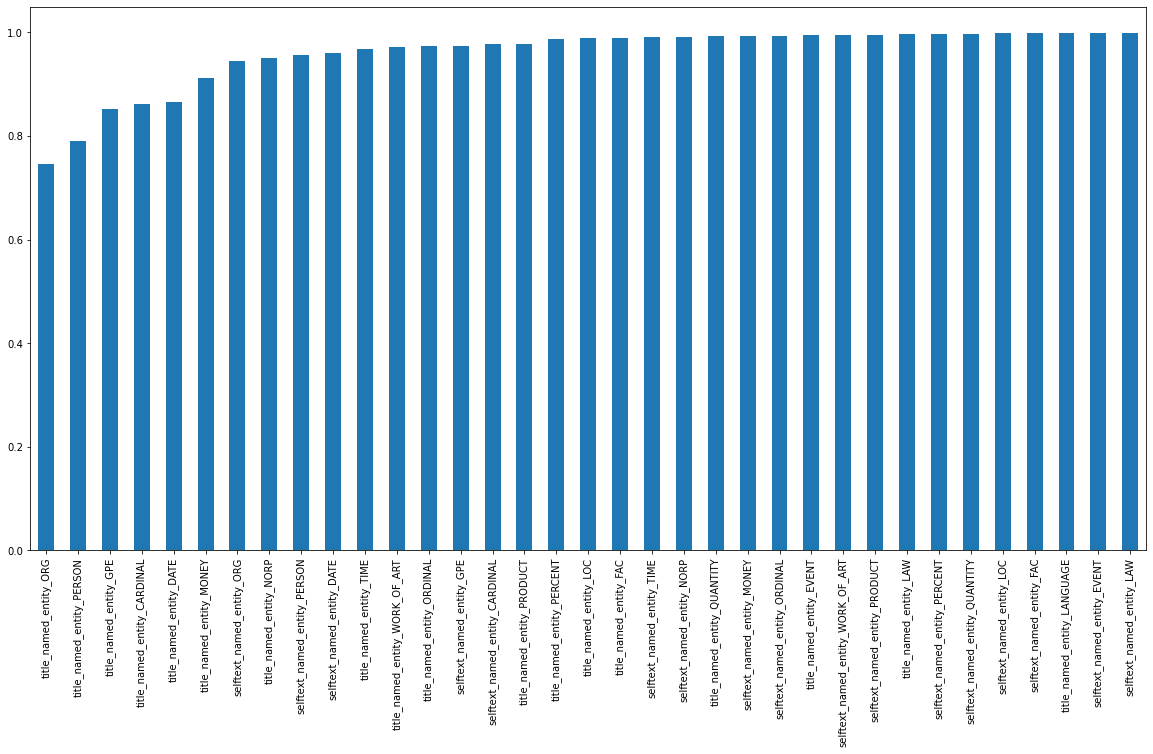

In [13]:
named_entity_cols = [col for col in results_df.columns if col.find('named_entity') > 1]
(results_df[named_entity_cols].isna().sum()/4192).sort_values().plot(kind = 'bar',figsize = (20,10))

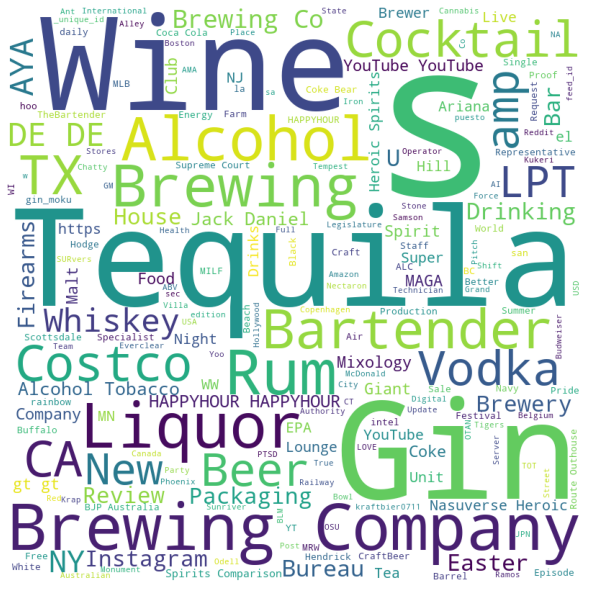

In [14]:
generate_word_bubble(results_df.title_named_entity_ORG.dropna())

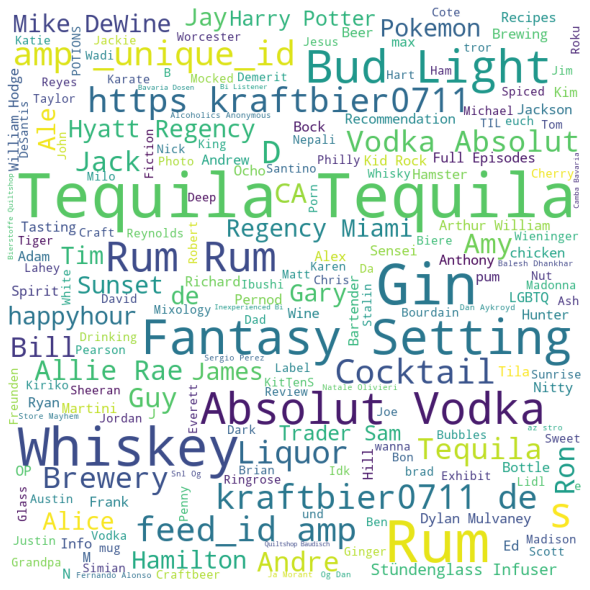

In [15]:
generate_word_bubble(results_df.title_named_entity_PERSON.dropna())

## LLM Features

### Relevance

#### Evaluating token cost

In [60]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')



curie_cost = 0.002 # per 1k tokens


total_tokens = 0
for i, row in results_df.iterrows():
    tokens = evaluator.get_tokens(row['title'])
    if not pd.isna(row.selftext):
        tokens += evaluator.get_tokens(row['selftext'])
    total_tokens+=tokens

projected_cost = (total_tokens/1000) * curie_cost
projected_cost = locale.currency(projected_cost, grouping=True)
print(f'''
total_tokens: {total_tokens}
average_tokens: {total_tokens/i+1}
projected_cost: {projected_cost}
''')


total_tokens: 436131
average_tokens: 105.06370794559771
projected_cost: $0.87



`engine = gpt-3.5-turbo`

**$0.002 / 1K tokens**

In [28]:
content = '''Wife and I went to Mexico for our honeymoon. I had the idea of buying a bottle of tequila and drinking a shot every anniversary. It broke on the way home.'''
prompt = evaluator.relevance_prompt(content)
relevance = evaluator.get_completion(prompt)
relevance = evaluator.strip_punctuation(relevance)
relevance

'Yes'

`engine = "text-curie-001"`

Curie
**$0.0020 / 1K tokens**

In [39]:
content = 'Is there any way to fix my series X’s case? Rubbing alcohol went on it and took off some of the paint making it look oily'
prompt = evaluator.relevance_prompt(content)
response = evaluator.evaluate_prompt(promp,engine = "text-curie-001")
response

'No'

In [40]:
content = '''Playoff mode activated: I'm giving up alcohol and fapping until the Laker's postseason is over.'''
prompt = f'''"{content}" is this related to alcoholic beverages? '''
prompt = evaluator.relevance_prompt(content)
response = evaluator.evaluate_prompt(prompt,engine = "text-curie-001")
response

'Yes'

In [118]:
content = results_df.loc[1, 'title']
prompt = f'''
        Consider the topics and subject matter in Reddit post below (delimited by brackets).
        Consider the difference between alcohol used in medicine and cleaning and alcohol used for human consumption.
        Is the subject matter in the Reddit post related to alcoholic beverages?
        Answer the question with either a Yes or a No.

        content: <{content}>

        Answer:'''
response = evaluator.evaluate_prompt(prompt,engine = "text-curie-001")

print(f'''
print: {content}
prompt: {prompt}
response: {response}

''')


print: Life is better in every way when you ditch alcohol.
prompt: 
        Consider the topics and subject matter in Reddit post below (delimited by brackets).
        Consider the difference between alcohol used in medicine and cleaning and alcohol used for human consumption.
        Is the subject matter in the Reddit post related to alcoholic beverages?
        Answer the question with either a Yes or a No.

        content: <Life is better in every way when you ditch alcohol.>

        Answer:
response: Yes




In [37]:
evaluator._setup_api_connection()

API key loaded from api_key.pkl


In [47]:
def relevance_prompt(title, selftext):
    prompt = f'''
        Consider the topics and subject matter in Reddit post below (delimited by brackets).
        Consider the difference between alcohol used in medicine and cleaning and alcohol used for human consumption.
        Is the subject matter in the Reddit post related to the type of alcohol that is intended for human consumption?
        Acceptable answers include: ['Yes', 'No'].
        
        title: <{title}>
        selftext: <{content}>

        Answer:'''
    return prompt

In [48]:
%%time
import time

supervise = 'y'

# hitting rate limit error
for i, row in results_df.iterrows():
    if pd.isna(row.selftext): selftext = 'none'
    else: selftext = row['selftext']
    prompt = relevance_prompt(row['title'], selftext)
    
    
    if supervise == 'y':
        supervise = input("Enter 'y' to keep supervising, enter 'x' to end: ")
    if supervise == 'x':
        break
                          
    
    try: 
        response = evaluator.get_completion(prompt)
        results_df.loc[i,'title_gpt35_turbo_relevance'] = response
        clear_output(wait = True)
        print(f'''
        subreddit: {row['subreddit']}
        title: {row['title']}
        selftext: {selftext}
        
        response: {response}
        ''')
        
        
        time.sleep(0.5)
    except RateLimitError: 
        time.sleep(60)
        response = evaluator.get_completion(prompt)
        results_df.loc[i,'title_gpt35_turbo_relevance'] = response
        
        clear_output(wait = True)
        print(f'''
        subreddit: {row['subreddit']}
        title: {row['title']}
        selftext: {selftext}
        
        response: {response}
        ''')


        subreddit: unpopularopinion
        title: Life is better in every way when you ditch alcohol.
        selftext: I was never a problematic drinker, but did always used to enjoy the social perks I thought came with alcohol. 

As I've got older, I've realised that a lot of these perks can be enjoyed without consuming overpriced posionous liquid. 

I made the decision a while back to cut out alcohol all together and I've found the following benefits

1. I can always drive if needed
2. Soft drinks are cheaper and normally healthier.
3. Weight is easier to manage.
4. Going out costs less. Not only the cost in drinks, but also taxis
5. I forgot how a hangover feels
6. My skin is better
7. I remember nights out more
8. Inhibitions exist for a reason. I can control if I choose to loosen them
9. The peace of mind that comes from not regularly introducing an addictive substance into your body. 
10. Zero chance of things getting out of hand and me waking up with regrets. 

Those are 10 b

Enter 'y' to keep supervising, enter 'x' to end:  x


CPU times: total: 0 ns
Wall time: 21.9 s


In [31]:
results_df.loc[results_df['title_gpt35_turbo_relevance'] == 'Yes.','title_gpt35_turbo_relevance'] = 'Yes'

results_df.title_gpt35_turbo_relevance.value_counts().to_clipboard()

In [28]:
results_df.loc[results_df['title_gpt35_turbo_relevance'] == 'No. The subject matter in the Reddit post is about a professional esports match between two teams, not about alcoholic beverages.', 'title_gpt35_turbo_relevance'] = 'No'


In [32]:
results_df.to_csv('./data/relevance.csv')

In [33]:
results_df.to_clipboard()

In [117]:
results_df[results_df['selftext_curie_relevance'] == 'No']

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,...,title_named_entity_LAW,selftext_named_entity_FAC,title_named_entity_LANGUAGE,selftext_named_entity_LOC,selftext_named_entity_LAW,selftext_named_entity_EVENT,title_spacy_relevance,selftext_spacy_relevance,title_curie_relevance,selftext_curie_relevance
1,2023-03-01 16:42:49-06:00,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,Yes,No
2,2023-03-02 15:30:39-06:00,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
6,2023-04-04 20:21:30-05:00,1.680658e+09,Wellbutrin_Bupropion,t5_2dmvki,Hello! So I've been on wellbutrin XL 150 MG fo...,t2_1sjey51m,Wellbutrin and Alcohol?,t3_12c3pi8,12c3pi8,NomadicMaeve,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
14,2023-03-31 13:27:55-05:00,1.680287e+09,unpopularopinion,t5_2tk0s,My sister is hosting a game night tomorrow whi...,t2_tprof1qu,"If you’re hosting something at your house, gue...",t3_127ugpb,127ugpb,venomous-harlot,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
19,2023-04-02 16:36:28-05:00,1.680471e+09,unpopularopinion,t5_2tk0s,I think these two go under the same category b...,t2_op8ccozj,"I hate when people say ""sleep with"" to describ...",t3_129z24h,129z24h,Rob06422,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,2014-06-01 11:00:50-05:00,1.401638e+09,Showerthoughts,t5_2szyo,I'd like to think so.,t2_650t7,Would vampires worry about contracting HIV? #D...,t3_271bq5,271bq5,enuigl,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
4182,2014-06-24 12:29:20-05:00,1.403631e+09,pcmasterrace,t5_2sgp1,THANK YOU!!! I can't say it enough times. Than...,t2_89yio,Thank you /u/drinkresponsibly. You are awesome...,t3_28zclg,28zclg,Slytren,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
4188,2021-03-27 12:33:25-05:00,1.616866e+09,SanJoseSharks,t5_2rdh2,Saturday game day against the 'Yotes! Get your...,t2_el29q,BZZT BZZT I'M YOUR ALARM CLOCK WAKE UP IT'S GA...,t3_meigx8,meigx8,X_The_Eliminator,...,NaN,NaN,NaN,NaN,NaN,GAME DAY,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No
4189,2021-05-05 15:12:35-05:00,1.620246e+09,tequila,t5_2ri8c,[https://theseventy6.com/blog/cointreau-margar...,t2_9xfiuoet,Cointreau Margarita 3 Ways,t3_n5pcpq,n5pcpq,Theseventy6,...,NaN,NaN,NaN,NaN,NaN,NaN,\n Evaluate the content below (delimite...,\n Evaluate the content below (delimite...,No,No


In [115]:
prompt = evaluator.relevance_prompt(row['title'])
print(prompt)


        Evaluate the content below (delimited by brackets).
        Does the content reference Mexico?
        Return either Yes or No.

        <Spritz>
        
        Answer:
        


In [17]:
evaluator = Content_Evaluator()
content = ''''Playoff mode activated: I'm giving up alcohol and fapping until the Laker's postseason is over.'''
response = evaluator.evaluate_questions(content)
response

API key loaded from api_key.pkl


{'category': 'Not related to alcoholic beverages',
 'summary': 'No alcohol or sex.'}

In [28]:
from content_evaluator import Content_Evaluator
import numpy as np
evaluator = Content_Evaluator()

df_sample = results_df.sample(n=1000).reset_index(drop = True)
df = df_sample.copy()

for i, row in df.iterrows():
    if (i == 0) | (i%10==0):
        clear_output(wait=True)
        print(f'''
        starting iteration: {i}
        ''')
    # collect title and selftext
    selftext = row['selftext']
    title = row['title']
    if type(selftext) == str:
        content = f"title: {title}, content:{selftext}"
    else:
        content = title
    # cutdown the number of tokens
    content = content[0:1000]
    # VADER sentiment
    df.loc[i, 'VADER sentiment'] = evaluator.vader_sentiment(content)
    # Named Entities
    df.loc[i,'Named Entities'] = str(evaluator.named_entity(content))
    # Relevance 
    prompt = evaluator.relevance_prompt(content)
    response = evaluator.evaluate_prompt(prompt,model ="text-davinci-003")
    df.loc[i, 'Relevant'] = response
    if response[0].upper() == 'Y':
        response = evaluator.evaluate_questions(content)
        df.loc[i, 'category'] = response['category']
        df.loc[i, 'summary'] = response['summary']
    
#     response = evaluator.evaluate_questions(content = content )
#     for col, answer in response.items():
#         results_df.loc[i, col] = answer

    
    


        starting iteration: 990
        


In [54]:
df.to_clipboard()

In [29]:
df.to_csv('./data/enriched_data.csv')

In [33]:
cols = ['subreddit', 'selftext', 'title','ups','num_comments','VADER sentiment', 'Named Entities','Relevant',
        'category','summary']
df[cols].sort_values(by = 'ups')

,subreddit,selftext,title,ups,num_comments,VADER sentiment,Named Entities,Relevant,category,summary
674,ottawa,"Hey all,\n\nI'm a big fan of drinking / mixing...",Best mixology classes for beginners,0,12,0.9417,['a fun evening'],Y,Cocktail recipes and tutorials,Cocktail mixing class.
512,Design,NaN,I’ve been thinking of creating a clothing bran...,0,1,0.2960,['HAPPYHOUR'],N,NaN,NaN
834,Mixology,"Hey,\n\nI'm sorry. I'm hope I'm right here. \*...","Present Idea for ""Hobby - Mixologe""?",0,3,0.9535,"['Ideas', 'this year']",Y,Cocktail recipes and tutorials,bar equipment
524,Kentucky,NaN,It’s almost time for NYE Live!,0,0,0.0000,['NYE'],N,NaN,NaN
39,AskReddit,I've been with this company for less than a ye...,How to overcome shyness in work parties/happyh...,0,10,0.4525,"['less than a year', 'hour', 'yesterday', 'one...",N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19,facepalm,NaN,20 year Mississippi news anchor Barbie Basset ...,57386,7175,-0.5574,"['20 year', 'Mississippi', 'Barbie', 'Fo Shizz...",N,NaN,NaN
124,WinStupidPrizes,NaN,Blowing a fire with vodka,60512,1486,-0.3400,None,Y,Not related to alcoholic beverages,"fire, vodka, blowing"
599,WhitePeopleTwitter,NaN,Drinking from straws.,72588,15614,0.0000,None,N,NaN,NaN
734,MurderedByWords,NaN,Carding for drinks is literally racism,73123,2146,-0.6249,None,N,NaN,NaN


<AxesSubplot:>

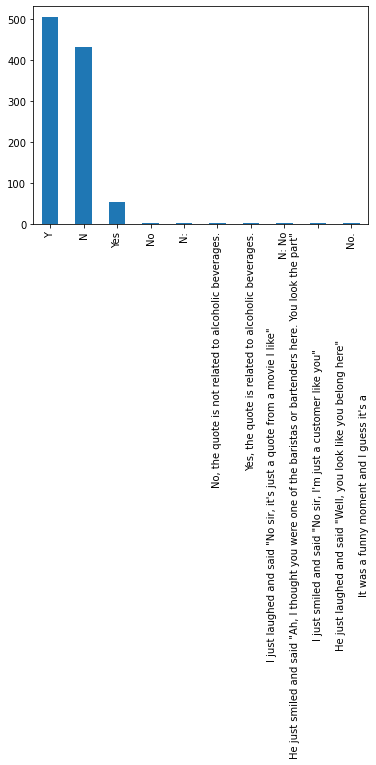

In [31]:
df.Relevant.value_counts().plot(kind = 'bar')

In [61]:
categories = ['Cocktail recipes and tutorials','Wine and beer recommendations','Party and event photos',
                      'Alcohol-related memes and humor','Reviews of bars and restaurants','Alcohol-related news and trends',
                      'Personal stories and experiences','Celebrity endorsements and sponsorships',
                    'Health and wellness tips','Advocacy and activism', 'Not related to Alcohol Beverages']
df[(~df.category.isin(categories)) & (~df.category.isna())]

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,num_comments,url,upvote_ratio,ups,search_term,VADER sentiment,Named Entities,Relevant,category,summary
7,1.679683e+09,1.679683e+09,drunk,t5_2ql00,NaN,t2_6xgtybj9,"Starting a bit early today, bought 14 beers an...",t3_120tc67,120tc67,Educational_Ad_3063,11,https://i.redd.it/suj88cysurpa1.jpg,0.99,93,vodka,0.0000,"['early today', '14', 'Friday']",Y,Not related to alcoholic beverages,"alcohol, party, Friday"
9,1.680994e+09,1.680994e+09,Military,t5_2qh8y,NaN,t2_72j6tgvr,After field shower beer...,t3_12g100s,12g100s,chair-borne1,42,https://i.redd.it/vwojlr9h6ssa1.jpg,0.98,2878,beer,0.0000,None,Y,Not related to alcoholic beverages,After field shower beer.
14,1.681917e+09,1.681917e+09,anchorage,t5_2qwcp,NaN,t2_bjk39xo,Whiskey &amp; Ramen in Imbibe Magazine,t3_12rwg88,12rwg88,sailrgrl,17,https://imbibemagazine.com/inside-look-whisky-...,0.77,17,whiskey,0.0000,"['Whiskey &', 'Ramen', 'Imbibe Magazine']",Y,"""Reviews of bars and restaurants""",Whiskey and ramen.
21,1.677388e+09,1.677388e+09,LivestreamFail,t5_38jf0,NaN,t2_bbop2xgi,JustaMinx drops her bottle of whiskey after dr...,t3_11c62zb,11c62zb,ElectricalGoose4029,299,https://clips.twitch.tv/LachrymoseObliviousSan...,0.75,543,whiskey,0.0000,None,Y,"""Alcohol-related memes and humor""",Drunkenness and clumsiness.
37,1.681132e+09,1.681132e+09,conspiracy,t5_2qh4r,I used to drink average socially acceptable am...,t2_dz8todsa,Alcohol is the most widely accepted use of min...,t3_12hiaqw,12hiaqw,ipetgoat1984,474,https://www.reddit.com/r/conspiracy/comments/1...,0.89,1080,alcohol,0.7251,"['five years', '1000%']",Y,Not related to alcoholic beverages,Alcohol control and productivity.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,1.679839e+09,1.679839e+09,notlikeothergirls,t5_34pb7,NaN,t2_hjn71f4v,Not like other girls because she drinks whiske...,t3_122mv34,122mv34,rinaroo24,96,https://i.redd.it/6ybj9wg4s4qa1.jpg,0.99,826,drinks,-0.2755,None,Y,Not related to alcoholic beverages,"Different, drinks whiskey."
977,1.679362e+09,1.679362e+09,whiskey,t5_2r06y,I won a lottery paid $95 with tax for this non...,t2_vkb7q8dn,The only benefit of state control liquor,t3_11x2r8e,11x2r8e,run4whiskey,31,https://i.redd.it/f8p6x578d1pa1.jpg,0.96,128,liquor,0.7717,['95'],Y,"""Alcohol-related news and trends""",The content is about a person who won a lotter...
982,1.675781e+09,1.675781e+09,Damnthatsinteresting,t5_2xxyj,NaN,t2_5ksnwvwg,How Tequila is made from Agave.,t3_10w3i4p,10w3i4p,Ocelot859,41,https://v.redd.it/n6giewyg3sga1,0.98,1012,tequila,0.0000,"['Tequila', 'Agave']",Y,"""Tequila is made from Agave.""",Tequila is made from agave.
989,1.677306e+09,1.677306e+09,u_Less-Morning-8163,t5_37tt7k,NaN,t2_8dc2k1w1,Wieninger Bock Biere - https://kraftbier0711.d...,t3_11bdwhj,11bdwhj,Less-Morning-8163,0,https://kraftbier0711.de/wieninger-bock-biere/...,1.00,2,craftbeer,0.0000,['Wieninger Bock Biere - https://kraftbier0711...,Y,Beer recommendations,Bock beer from Wieninger.


In [40]:
df[df.category == "Personal stories and experiences"].sort_values(by = 'ups',ascending = False)

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,num_comments,url,upvote_ratio,ups,search_term,VADER sentiment,Named Entities,Relevant,category,summary
169,1.673208e+09,1.673208e+09,CasualUK,t5_3j2jr,NaN,t2_hnz21y96,Is drinking 2 bottles of wine an unacceptable ...,t3_106sjnd,106sjnd,Necessary-Trash-8828,1574,https://www.reddit.com/r/CasualUK/comments/106...,0.92,4774,wine,-0.4588,"['2', 'Sunday', '1300', 'second', '2000']",Y,Personal stories and experiences,Too much wine.
843,1.679049e+09,1.679049e+09,teenagers,t5_2rjli,as hard as you can and started healthy habits....,t2_tqe273a,I’m 31 and weirdly I get recommended this sub ...,t3_11tn50q,11tn50q,Kaje26,476,https://www.reddit.com/r/teenagers/comments/11...,0.91,4761,drinking,0.9796,None,Yes,Personal stories and experiences,Don't do drugs
595,1.679237e+09,1.679237e+09,traaaaaaannnnnnnnnns,t5_2uog0,NaN,t2_z5lzp,So the bartender winked at me and gave me a fr...,t3_11vn1mu,11vn1mu,WickedDarkStorm,27,https://i.redd.it/m0h5rdzxipoa1.jpg,1.00,2252,bartender,0.5106,None,Y,Personal stories and experiences,Free drink.
924,1.680092e+09,1.680092e+09,selfie,t5_2w2f5,NaN,t2_6cgarsfgw,4 months sober from alcohol today! Every day j...,t3_125mcj6,125mcj6,winter-iscumming,236,https://i.redd.it/ky8fa8aaopqa1.png,0.99,2205,alcohol,0.4926,"['4 months', 'today', 'Every day', '28f']",Y,Personal stories and experiences,"Sober, happy, proud."
933,1.677711e+09,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,544,https://www.reddit.com/r/unpopularopinion/comm...,0.89,2202,alcohol,0.9846,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",Y,Personal stories and experiences,"No hangovers, saves money, better skin."
913,1.679998e+09,1.679998e+09,stopdrinking,t5_2s7yr,I LOVE what I do. I hate drinking everyday. I’...,t2_gf5iwtn0,I’m a bartender that has been drinking on the ...,t3_124jszm,124jszm,blindbatcat,92,https://www.reddit.com/r/stopdrinking/comments...,1.00,1384,bartender,0.9678,"['second', 'two', 'these two days']",Y,Personal stories and experiences,Sobriety in bartending.
590,1.681807e+09,1.681807e+09,Nails,t5_2qhwc,Hating myself right now,t2_tzl31gi7,Did my nails after 3 wines. Woke up to this.,t3_12qgccs,12qgccs,bluecottonpants,70,https://i.redd.it/il5gnb7ucnua1.jpg,0.98,902,wine,0.0000,['3'],Y,Personal stories and experiences,"Nails, wine, regret."
175,1.680782e+09,1.680782e+09,stopdrinking,t5_2s7yr,"Been about 6 months for me now, and I think so...",t2_gjwl8,What's your favorite thing about not drinking?,t3_12dhps6,12dhps6,username0304,559,https://www.reddit.com/r/stopdrinking/comments...,0.99,881,drinking,-0.1260,['about 6 months'],Y,Personal stories and experiences,Not drinking alcohol.
22,1.680991e+09,1.680991e+09,unpopularopinion,t5_2tk0s,When you drink at home during the day with you...,t2_cy4poaz6,Day drinking at home with friends better than ...,t3_12fzjse,12fzjse,InternalOperation729,130,https://www.reddit.com/r/unpopularopinion/comm...,0.91,746,drinking,0.8750,"['night', 'the day', '11pm', 'the next day', '...",Y,Personal stories and experiences,Comfortable day drinking.
238,1.681384e+09,1.681384e+09,onmww,t5_ekh3m,NaN,t2_kheq9gl5,• she lived for nights thick with lust and rom...,t3_12kl74t,12kl74t,BlondeVixxen,87,https://i.redd.it/wi0a09jaeota1.jpg,0.99,677,wine,0.7845,['nights'],Y,Personal stories and experiences,"passionate, romantic, sensual"


<AxesSubplot:>

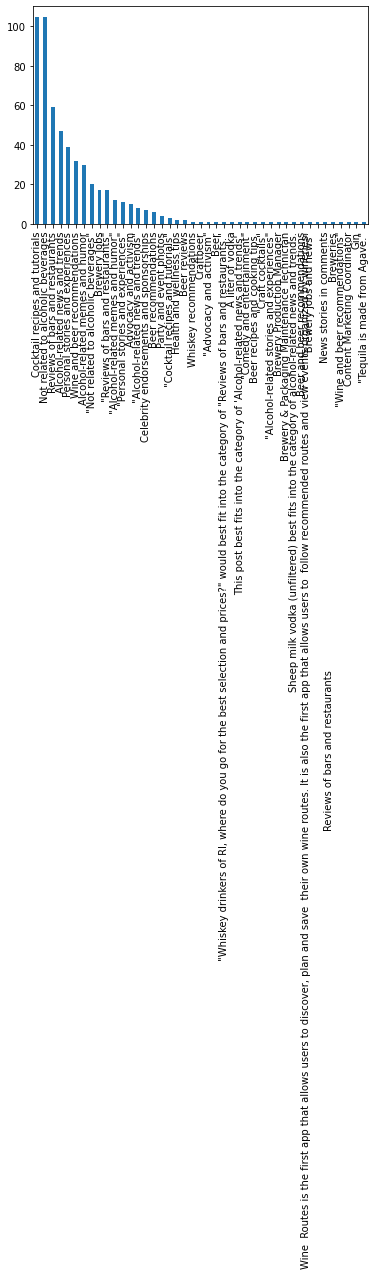

In [34]:
df.category.value_counts().plot(kind = 'bar')

In [48]:
cols = ['subreddit','selftext','title','ups','category','sentiment','summary','topics']
results_df[cols].to_clipboard()

In [30]:
results_df.category.unique()

array(['Not related to alcohol', 'Cocktail recipes and tutorials',
       'Wine and beer recommendations',
       '"Alcohol-related memes and humor"',
       '"Alcohol-related news and trends"', '"Party and event photos"',
       'Personal stories and experiences',
       'Alcohol-related memes and humor',
       'Alcohol-related news and trends',
       'Reviews of bars and restaurants',
       '"Personal stories and experiences"', '"Not related to alcohol"',
       'Party and event photos',
       'Celebrity endorsements and sponsorships',
       '"Wine and beer recommendations"',
       '"Reviews of bars and restaurants"', 'Health and wellness tips'],
      dtype=object)

### HuggingFace <a name = 'huggingface' /></a>

[return](#toc)

In [3]:
import transformers
from transformers import pipeline

In [7]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.8445990085601807, 0.11197423189878464, 0.04342677444219589]}

In [51]:
%%time
candidate_labels = [
    "Cocktail recipes and drink recommendations for different occasions",
    "Personal stories and experiences related to alcohol consumption",
    "Promotions and advertisements for alcohol brands and products",
    'Not related to Alcohol Beverages'
]
classifier( content, candidate_labels)


CPU times: total: 6min 42s
Wall time: 6min 35s


{'sequence': 'Hey San Francisco - how do you "Spritz"? Do it the @lillet way. Cheers 🥂#drinkresponsibly #lillet #thelilletway #dessertwine #SF #sanfrancisco #outdoor#ooh #advertising #wallscapes #marketing \n\nhttps://preview.redd.it/lu81ozglb3e31.jpg?width=3061&amp;format=pjpg&amp;auto=webp&amp;v=enabled&amp;s=6e83c5670262eb164940d38ab6a5f188aa38ea92',
 'labels': ['Promotions and advertisements for alcohol brands and products',
  'Cocktail recipes and drink recommendations for different occasions',
  'Personal stories and experiences related to alcohol consumption',
  'Not related to Alcohol Beverages'],
 'scores': [0.5532870888710022,
  0.24495141208171844,
  0.18568484485149384,
  0.016076605767011642]}

In [54]:
%%time
content ='''Winelovers! please help me pick a food wine in France!'''

results = classifier( content, candidate_labels)


CPU times: total: 1min 51s
Wall time: 1min 11s


In [57]:
dict(zip(results['labels'],results['scores']))

{'Personal stories and experiences related to alcohol consumption': 0.4618803858757019,
 'Promotions and advertisements for alcohol brands and products': 0.33034393191337585,
 'Not related to Alcohol Beverages': 0.14022527635097504,
 'Cocktail recipes and drink recommendations for different occasions': 0.06755036860704422}

In [63]:
time.time()

1683564517.3893034

In [ ]:
%%time

candidate_labels = [
    "Cocktail recipes and drink recommendations for different occasions",
    "Personal stories and experiences related to alcohol consumption",
    "Promotions and advertisements for alcohol brands and products",
    'Not related to Alcohol Beverages'
]
exceptions = []

start_time = time.time()

for i, row in results_df.iterrows():
    try:
        results = classifier(row['title'], candidate_labels)
    except Exception as e:
        print(e)
        exceptions.append(e)
    results = dict(zip(results['labels'],results['scores']))
    for label, score in results.items():
        results_df.loc[i, label] = score
        
    wall_time = time.time() - start_time
    average_time = wall_time/(i+1)
    clear_output(wait=True)
    print(f'''
    wall_time: {wall_time}
    average_time: {average_time}
    finished {i+1} out of {len(results_df)}
    ''')


    wall_time: 143769.5386338234
    average_time: 96.48962324417677
    finished 1490 out of 4192
    


In [72]:
results_df

,created,created_utc,subreddit,subreddit_id,selftext,author_fullname,title,name,id,author,...,selftext_named_entity_FAC,title_named_entity_LANGUAGE,selftext_named_entity_LOC,selftext_named_entity_LAW,selftext_named_entity_EVENT,title_gpt35_turbo_relevance,Personal stories and experiences related to alcohol consumption,Not related to Alcohol Beverages,Cocktail recipes and drink recommendations for different occasions,Promotions and advertisements for alcohol brands and products
0,2023-01-10 22:32:41-06:00,1.673412e+09,Damnthatsinteresting,t5_2xxyj,NaN,t2_f8zi494m,"Contrary to popular belief,no amount of alcoho...",t3_108vj2n,108vj2n,UniqueCold3812,...,NaN,NaN,NaN,NaN,NaN,No,0.541369,0.303508,0.107252,0.047871
1,2023-03-01 16:42:49-06:00,1.677711e+09,unpopularopinion,t5_2tk0s,"I was never a problematic drinker, but did alw...",t2_a3ih64q1,Life is better in every way when you ditch alc...,t3_11fknkh,11fknkh,Pure_Club_8997,...,NaN,NaN,NaN,NaN,NaN,No. The subject matter in the Reddit post is n...,0.542131,0.363357,0.061250,0.033261
2,2023-03-02 15:30:39-06:00,1.677793e+09,loseit,t5_2rz8w,I'm not saying you can't lose weight while dri...,t2_1uc2ctml,"If you're serious about this, take a break fro...",t3_11geo7u,11geo7u,noodlesworldwide,...,NaN,NaN,NaN,NaN,NaN,Undetermined. The title of the post suggests a...,0.637188,0.264851,0.035762,0.062198
3,2023-01-31 17:27:18-06:00,1.675208e+09,AskReddit,t5_2qh1i,NaN,t2_2wguso99,"Redditors, why don't you drink alcohol or why ...",t3_10qdyyd,10qdyyd,LuGGooo,...,NaN,NaN,NaN,NaN,NaN,No. The subject matter in the Reddit post is n...,0.923903,0.037444,0.016643,0.022011
4,2023-04-07 13:41:35-05:00,1.680893e+09,therewasanattempt,t5_39ne7,NaN,t2_rabj2wla,to stay on the plane after an altercation with...,t3_12euyic,12euyic,timberdroid,...,NaN,NaN,NaN,NaN,NaN,Yes.,0.895531,0.045138,0.044293,0.015038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,2022-12-28 15:28:21-06:00,1.672263e+09,NewAlbanyIN,t5_fgz3n,NaN,t2_3alg9w10,In case you’re still looking for New Year’s Ev...,t3_zxlkk6,zxlkk6,Full_Mortgage_2612,...,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN
4188,2021-03-27 12:33:25-05:00,1.616866e+09,SanJoseSharks,t5_2rdh2,Saturday game day against the 'Yotes! Get your...,t2_el29q,BZZT BZZT I'M YOUR ALARM CLOCK WAKE UP IT'S GA...,t3_meigx8,meigx8,X_The_Eliminator,...,NaN,NaN,NaN,NaN,GAME DAY,Yes,NaN,NaN,NaN,NaN
4189,2021-05-05 15:12:35-05:00,1.620246e+09,tequila,t5_2ri8c,[https://theseventy6.com/blog/cointreau-margar...,t2_9xfiuoet,Cointreau Margarita 3 Ways,t3_n5pcpq,n5pcpq,Theseventy6,...,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN
4190,2019-08-02 14:52:47-05:00,1.564776e+09,u_DASHTWOINC,t5_eludg,"Hey San Francisco - how do you ""Spritz""? Do it...",t2_hecze,"Hey San Francisco - how do you ""Spritz""? Do it...",t3_cl90fx,cl90fx,DASHTWOINC,...,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN


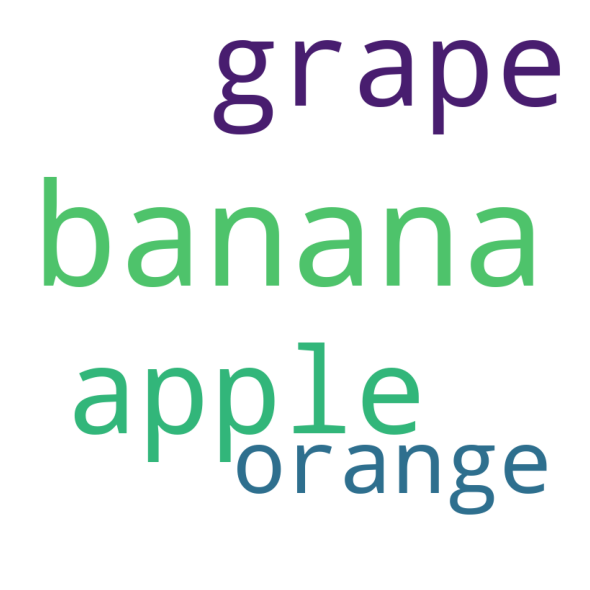

In [43]:
# Example usage
data = pd.Series(['apple', 'banana', 'apple', 'orange', 'grape', 'banana', 'banana', 'grape'])
generate_word_bubble(data)


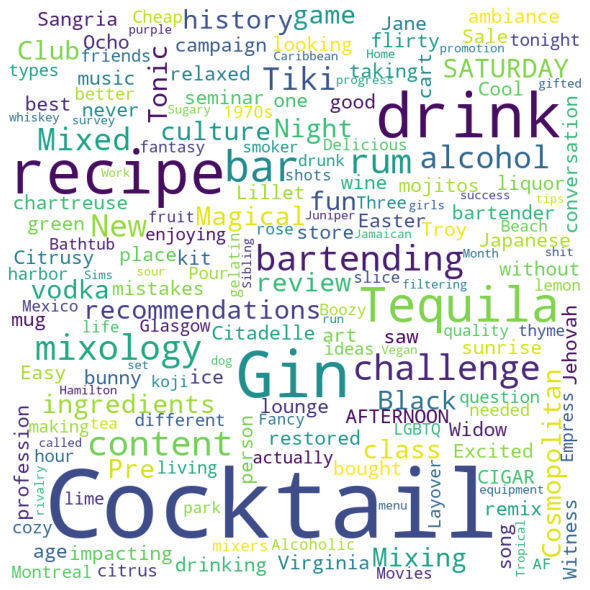

In [47]:
generate_word_bubble(df[df.category == 'Cocktail recipes and tutorials']['summary'])

C:\Users\stvnc\AppData\Local\Temp\ipykernel_60324\227108705.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  generate_word_bubble(df['Named Entities'].str.replace('[','').str.replace(']','').str.replace('None','').str.replace("'",''))


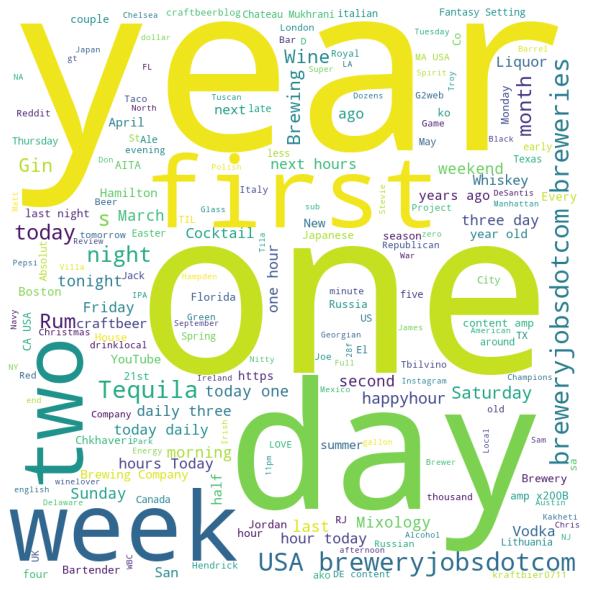

In [52]:
generate_word_bubble(df['Named Entities'].str.replace('[','').str.replace(']','').str.replace('None','').str.replace("'",''))

In [52]:
cols = ['subreddit','selftext','title','ups','category','sentiment','summary','topics']
category = '"Wine and beer recommendations"'
category = 'Personal stories and experiences'
category = '"Reviews of bars and restaurants"'
category = 'Wine and beer recommendations'
results_df[results_df['category']==category].sort_values(by='ups',ascending = False)[cols].to_clipboard()

In [20]:
results_df[results_df.2question_0 == 'Category: Reviews of gaming consoles and accessories'].title.iloc[0]

'Is there any way to fix my series X’s case? Rubbing alcohol went on it and took off some of the paint making it look oily'

In [ ]:
results_df.to_csv('./data/enriched_alcohol_reddit_v2.csv')

In [ ]:
categories = ['Cocktail recipes and tutorials','Wine and beer recommendations','Party and event photos','Alcohol-related memes and humor',
              'Reviews of bars and restaurants','Alcohol-related news and trends','Personal stories and experiences','Celebrity endorsements and sponsorships',
              'Health and wellness tips','Advocacy and activism']
